In [1]:
import os
import sys

# NOTE:
# This notebook assumes execution from the project root.
# It explicitly sets cwd to external/genomic-FM so GV-Rep loaders work.

os.chdir("../external/genomic-FM")
sys.path.append(".")

from src.dataloader.data_wrapper import RealClinVar

In [ ]:
loader = RealClinVar(num_records=156, all_records=False)
lc_data = loader.get_data(Seq_length=1024)

print("Number of Records:", len(lc_data))
print("Record length:",len(lc_data[0]))  # each record is a tuple (sequence, label)

lc_ref_sequences = [record[0][0] for record in lc_data]
lc_alt_sequences = [record[0][1] for record in lc_data]

lc_labels = [record[1] for record in lc_data]

print("Example reference sequence:", lc_ref_sequences[0])
print("Example alternative sequence:", lc_alt_sequences[0])
print("Unique labels in dataset:", set(lc_labels))

Number of Records: 155
Record length: 2
Example sequence: CTTTCTTGCGGAGATTCTCTTCCTCTGTGCGCCGGTCTCTCCCAGGACAGGCACAAACACGCACCTCAAAGCTGTTCCGTCCCAGTAGATTACCACTACTCAGGATAGGAAAAGAGAAGCAAGAGGCAGTAAGGAAATCAGGTCCTACCTGTCCCATTTAAAAAACCAGGCTCCATCTACTCCCAACCACCCTTGTCCTTTCTGGAGCCTAAGCTCCAGCTCCAGGTAGGTGGAGGAGAAGCCACAGGTTAAGAGGTCCCAAAGCCAGAGAAAAGAAAACTGAGTGGGAGCAGTAAGGAGATTCCCCGCCGGGGATGTGATGAGAGGTGGATGGGTAGTAGTATGGAAGAAATCGGTAAGAGGTGGGCCCAGGGGTCAGAGGCAAGCAGAGGCTGGGGCACAGCAGGCCAGTGTGCAGGGTGGCAAGTGGCTCCTGACCTGGAGTCTTCCAGTGTGATGATGGTGAGGATGGGCCTCCGGTTCATGCCGCCCATGCAGGAACTGTTACACATGTAGTTGTAGTGGATGGTGGTACAGTCAGAGCCAACCTAGGAGATAACACAGGCCCAAGATGAGGCCAGTGCGCCTTGGGGAGACCTGTGGCAAGCAGGGGAGGCCTTTTTTTTTTTTTTTTGAGATGGAATCTCGCTCTGTCGCCCAGGCTGGAGTGCAGTGGCGTGATCTCAGCTCACTGCAAGCTCCACCGCCCAGGTTCACGCCATTCTCCTTCCTCAGCCTCCCGAGTAGCTGGGACTACAGGTGCCCAGCACCACGCCCGGCTAATTTTTTTTTGTATTTTTCAGTAGAGACGGGGTTTCACCGTTAGCCAGGATGGTCTCGATCTCCCAACCTCGTGATCCGCCTGCCTTGGCCTCCCAAAGTGCTGGGATTACAGGCATGAGCCACTGCGCCCAGCCAAGCAGGGGAGGCCCTTAGCCTCTG

Based on the average length, we can decide on a fixed length for tokenization. Because our tokenizer takes 6-mers, we can safely use 171 tokens and have all the sequences be properly tokenized.  

In [3]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

/opt/miniconda3/envs/mechanistic_interpretability/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Import the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-500m-multi-species", trust_remote_code=True)
model = AutoModelForMaskedLM.from_pretrained("InstaDeepAI/nucleotide-transformer-v2-500m-multi-species", trust_remote_code=True)

In [ ]:
# Temporarily bottleneck sequences for testing on my laptop, later move to colab
#lc_sequences = lc_sequences[:50]
#lc_labels = lc_labels[:50]

In [ ]:
# length to which the input sequences are padded
max_length = 171    # 2048, hence 12kbp context window


# Create a dummy dna sequence and tokenize it (6-mers if multiple of 6)
tokens_ids = tokenizer.batch_encode_plus(lc_sequences, return_tensors="pt", padding="max_length", max_length = max_length)["input_ids"]
print("Tokens shape:", tokens_ids.shape, "\n")

Tokens shape: torch.Size([50, 175]) 



In [7]:
attention_mask = tokens_ids != tokenizer.pad_token_id
print("Attention Mask", attention_mask)

torch_outs = model(
    tokens_ids,
    attention_mask=attention_mask,  # prevents attention to padding tokens
    output_attentions = True,
    encoder_attention_mask=attention_mask,
    output_hidden_states=True       # to get all layer embeddings
)

Attention Mask tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])


In [8]:
output_states = torch_outs.hidden_states

In [ ]:
print("Last Layer Embeddings shape:", output_states[-1].shape)
embeddings = output_states[-1]  # (B, L, D)

Last Layer Embeddings shape: torch.Size([50, 175, 1024])


### Logistic Regression on Final Layer Hidden States

In [ ]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

lc_labels = [0 if label == "Class 1" or label == "Class 2" else 1 for label in lc_labels]  # binary classification
print("Labels after binarization (0 for Class 1/2 and Class 1 for Class 3/4):", set(lc_labels))

# fit logistic regression on CLS token embeddings
clf = linear_model.LogisticRegression(max_iter=1000)
embeddings_set = embeddings[:,0,:].detach().numpy()  # use CLS token embeddings
X_train, X_test, y_train, y_test = train_test_split(embeddings_set, lc_labels, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
print("Training accuracy:", clf.score(X_train, y_train))
print("Test accuracy:", clf.score(X_test, y_test))

['Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1', 'Class 1']


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.str_('Class 1')

In [10]:
output_attentions = torch_outs.attentions

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_attention(attentions, attention_mask, seq_index=0, layer=-1, head=0, title=None, max_tokens=None):
    """
    attentions: tuple(list) where attentions[layer] is (B, H, L, L)
    attention_mask: (B, L) torch tensor with 1 for real tokens, 0 for PAD
    """
    A = attentions[layer][seq_index, head].detach().cpu().numpy()  # (L, L)
    m = attention_mask[seq_index].detach().cpu().numpy().astype(bool)  # (L,)

    # Keep only real tokens
    idx = np.where(m)[0]
    A = A[np.ix_(idx, idx)]

    # Optional truncate for readability
    if max_tokens is not None and A.shape[0] > max_tokens:
        A = A[:max_tokens, :max_tokens]

    plt.figure(figsize=(20, 10)) # Sets width to 10 inches, height to 5 inches
    plt.imshow(A, aspect="auto")
    plt.colorbar()
    plt.xlabel("Key token position")
    plt.ylabel("Query token position")
    if title is None:
        title = f"Attention | seq={seq_index} layer={layer} head={head} tokens={A.shape[0]}"
    plt.title(title)
    plt.show()


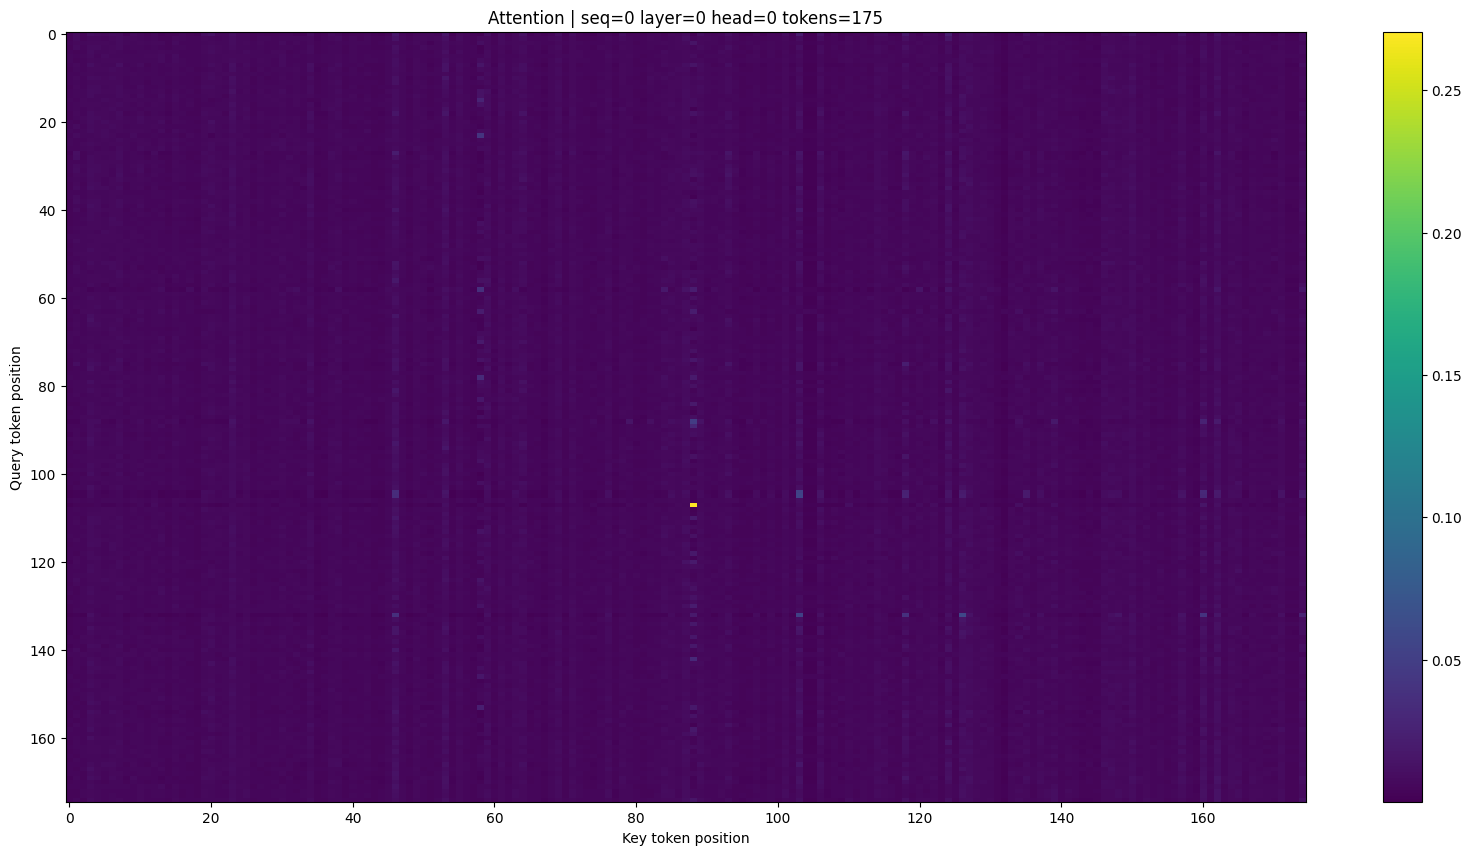

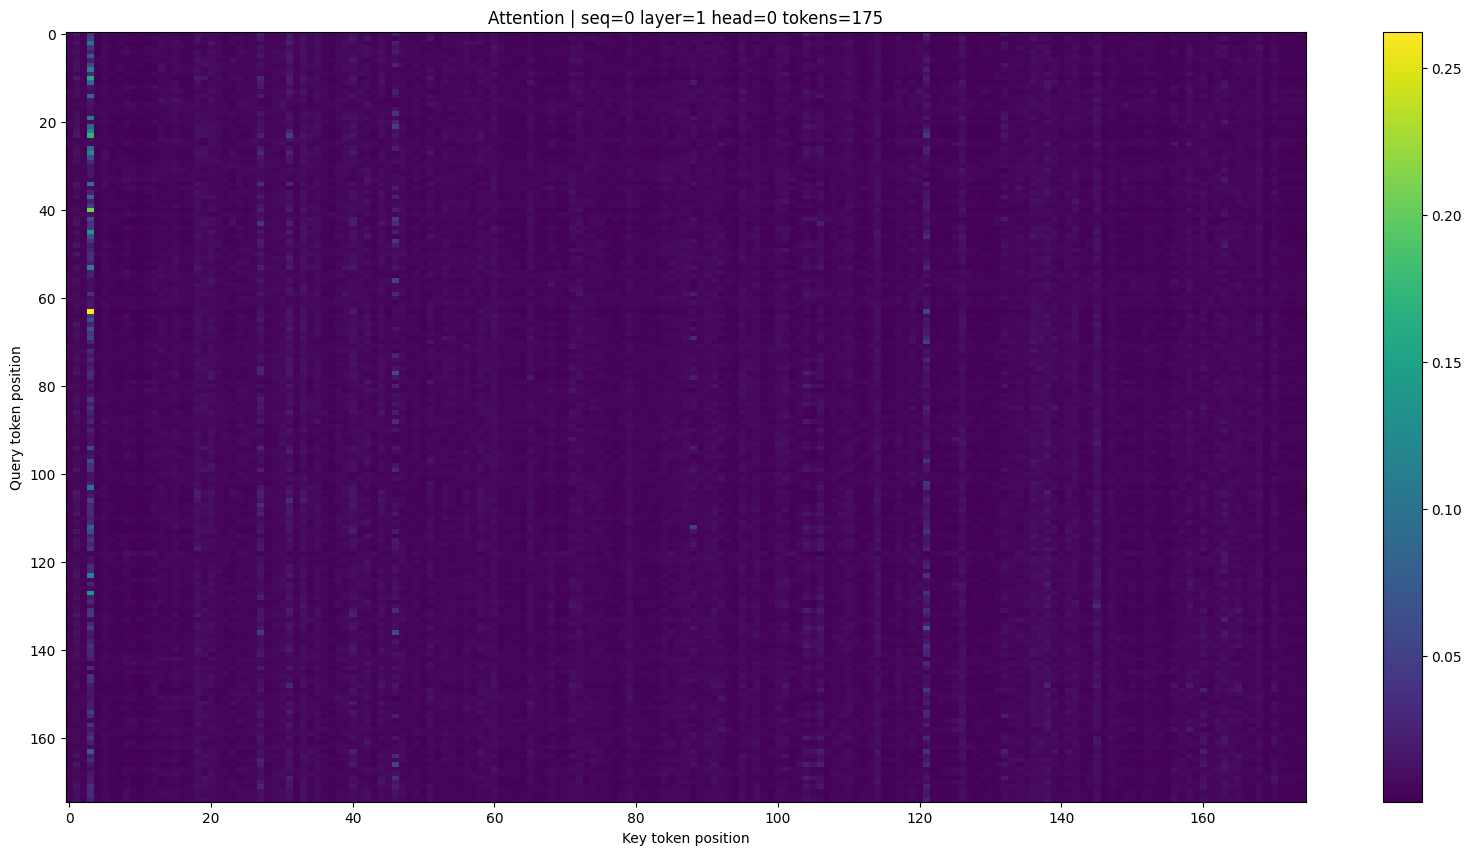

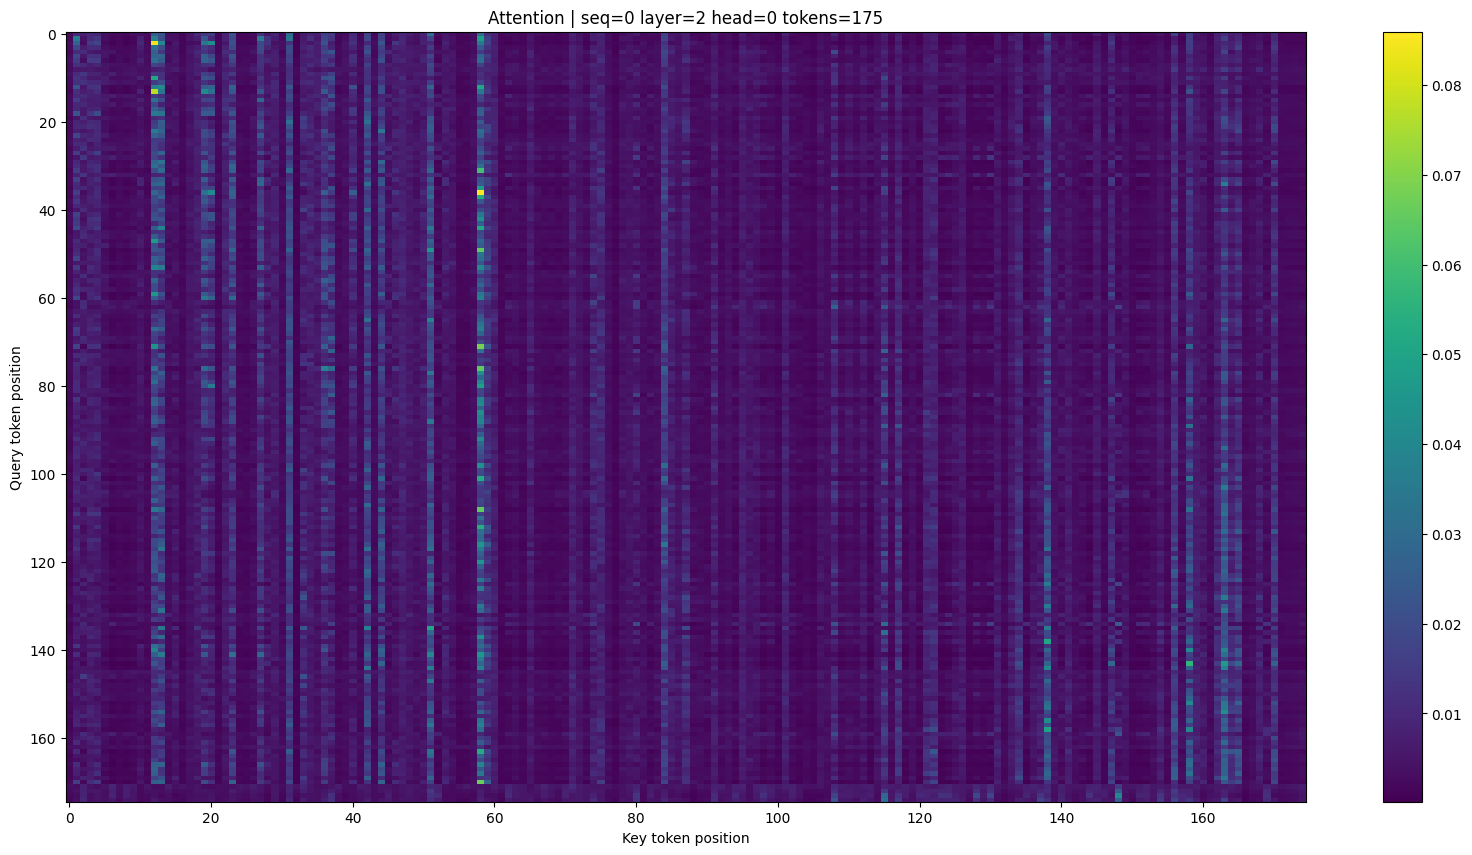

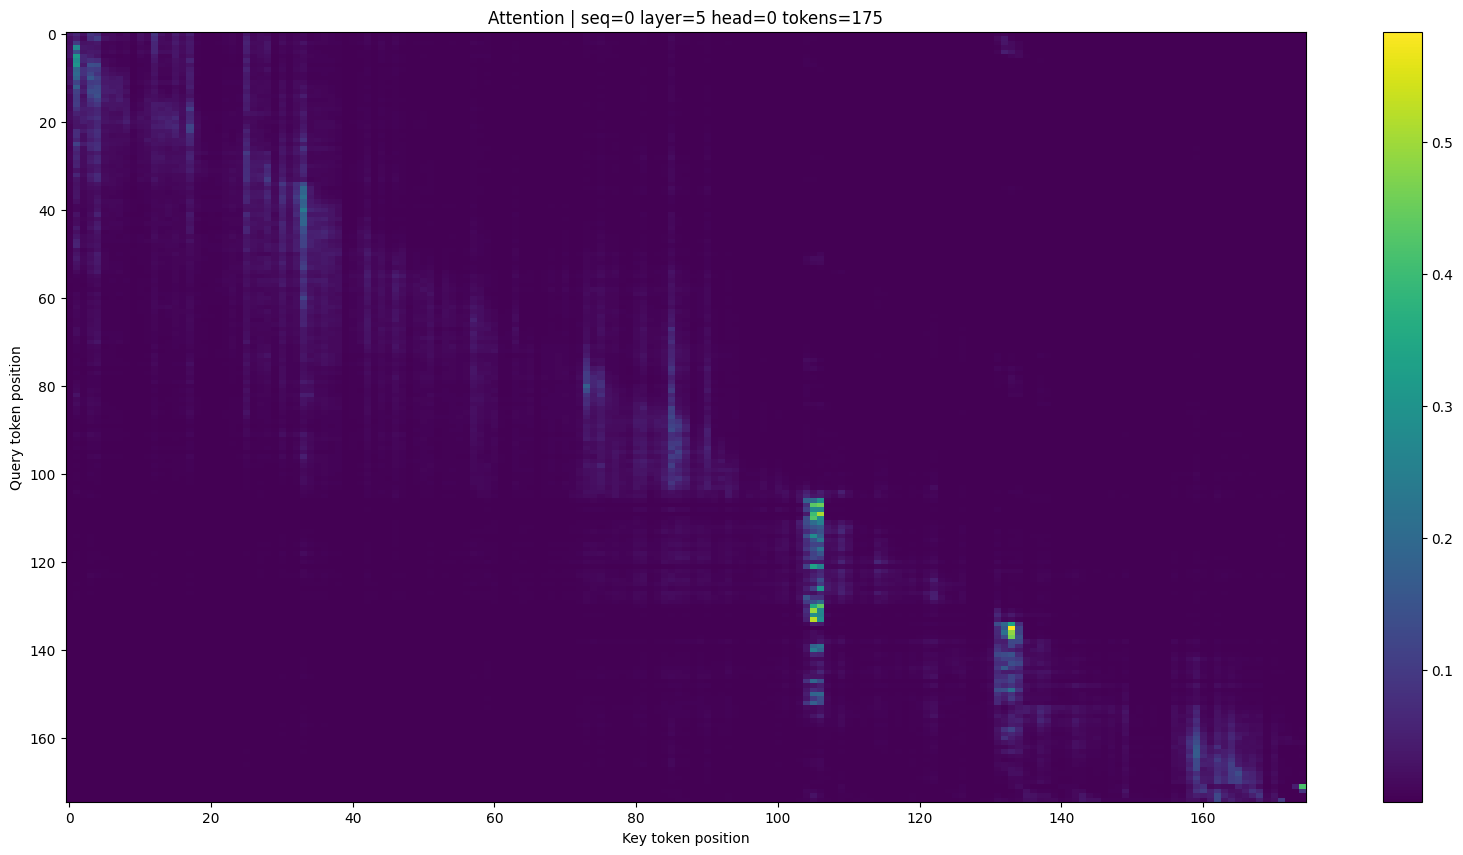

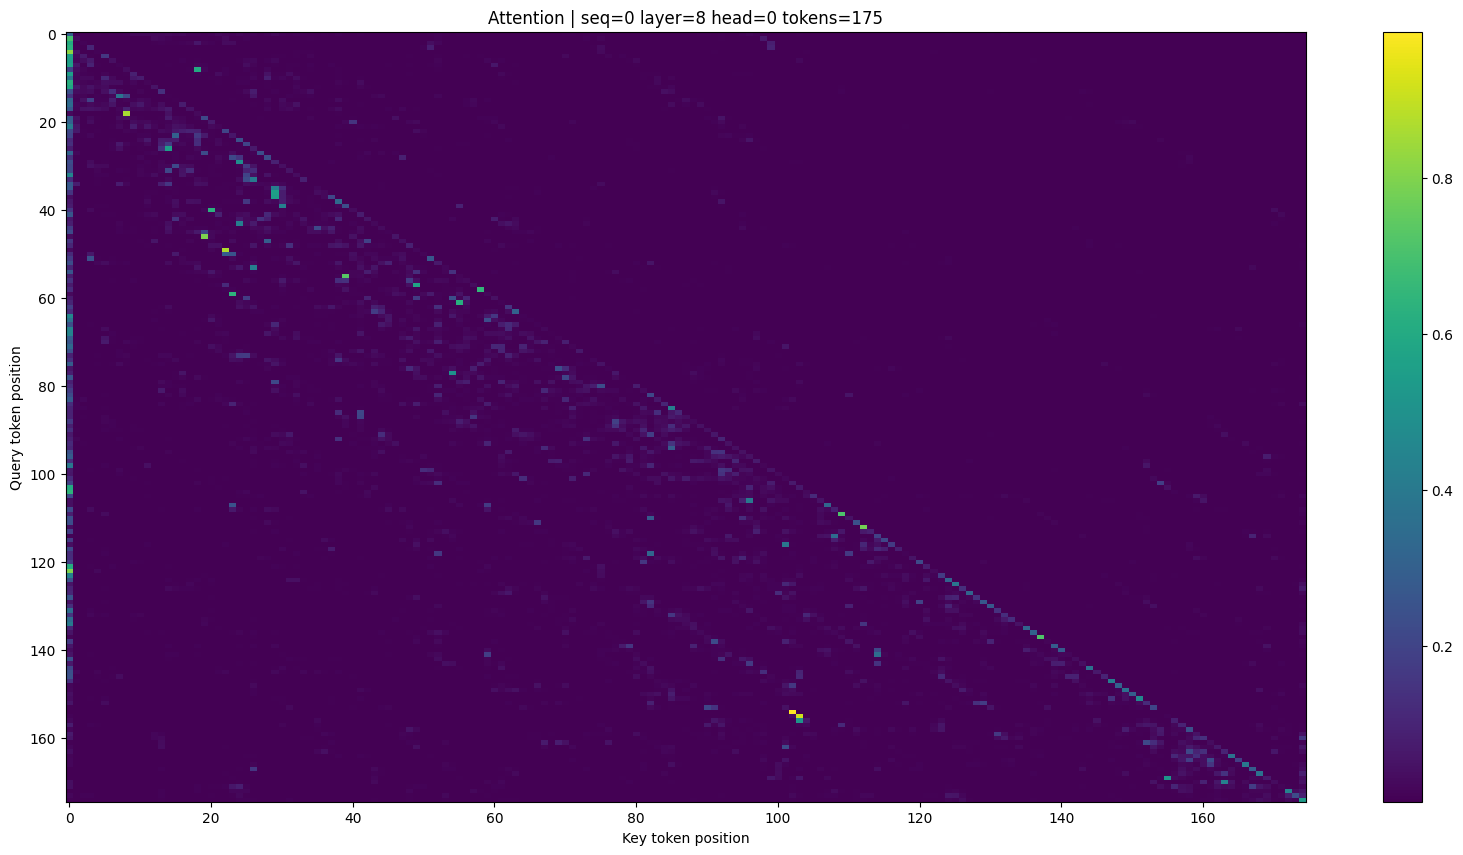

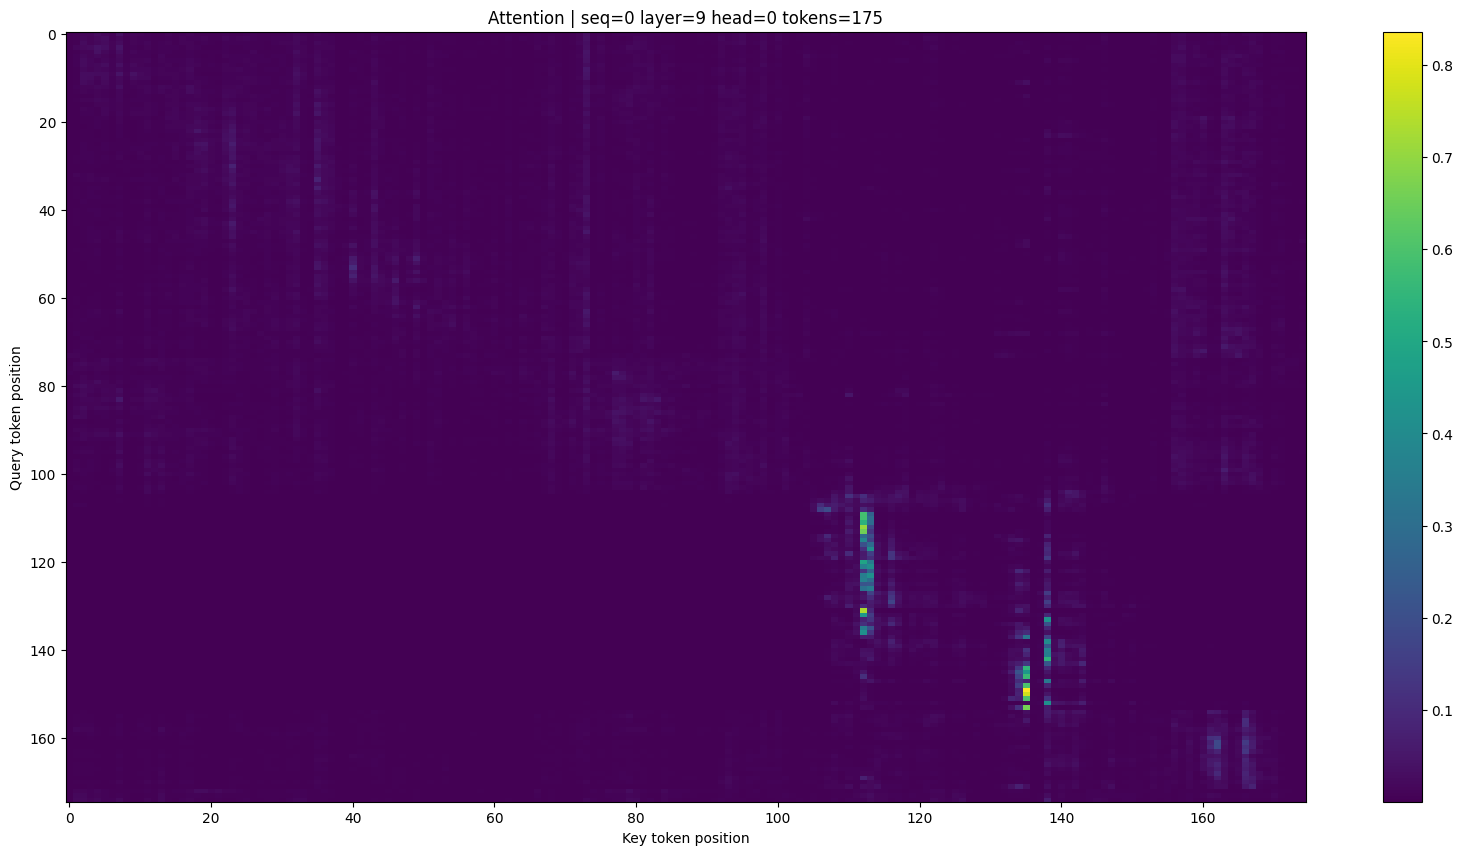

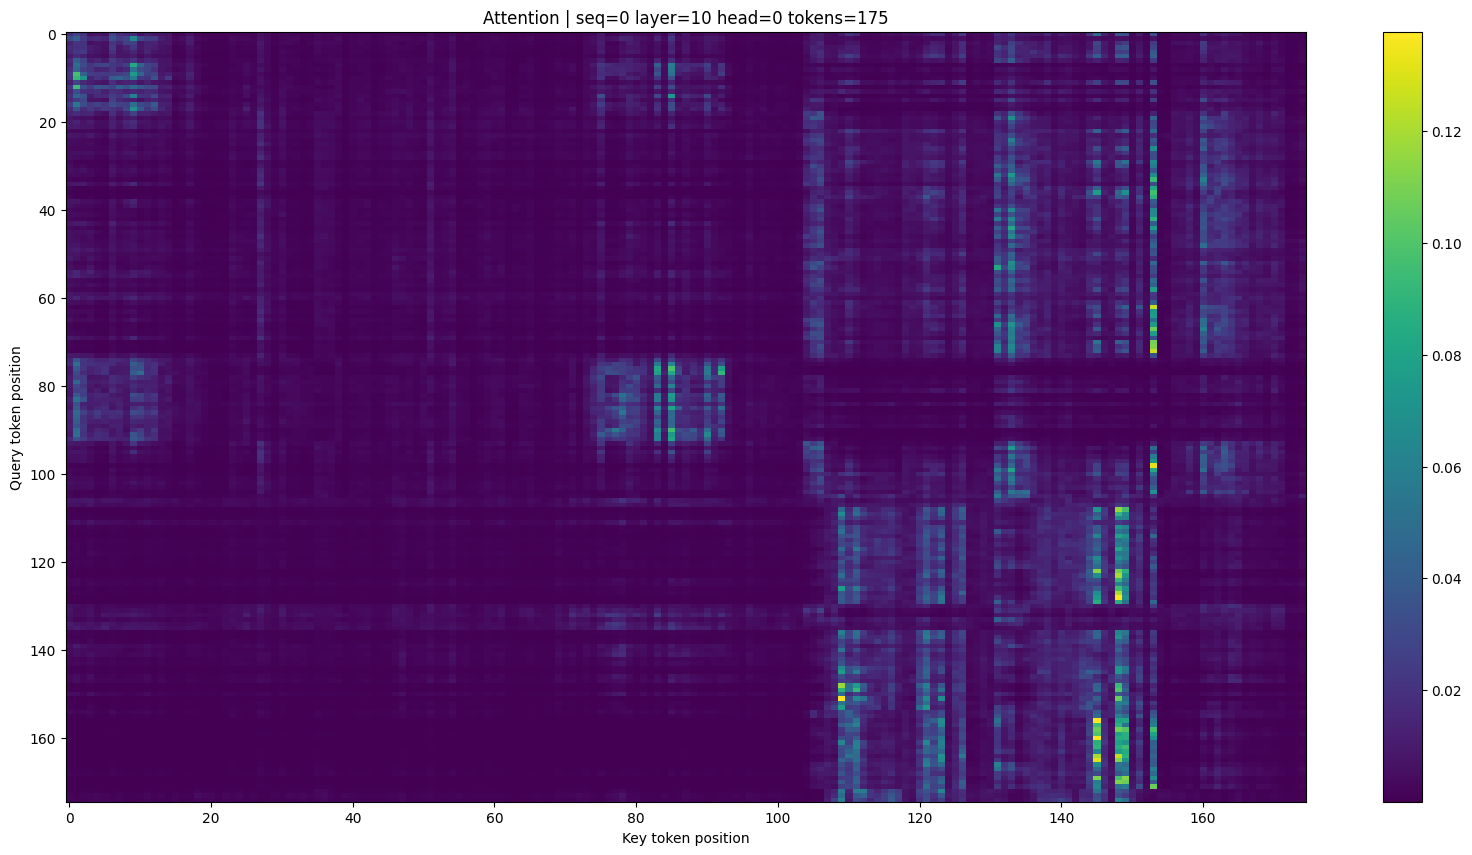

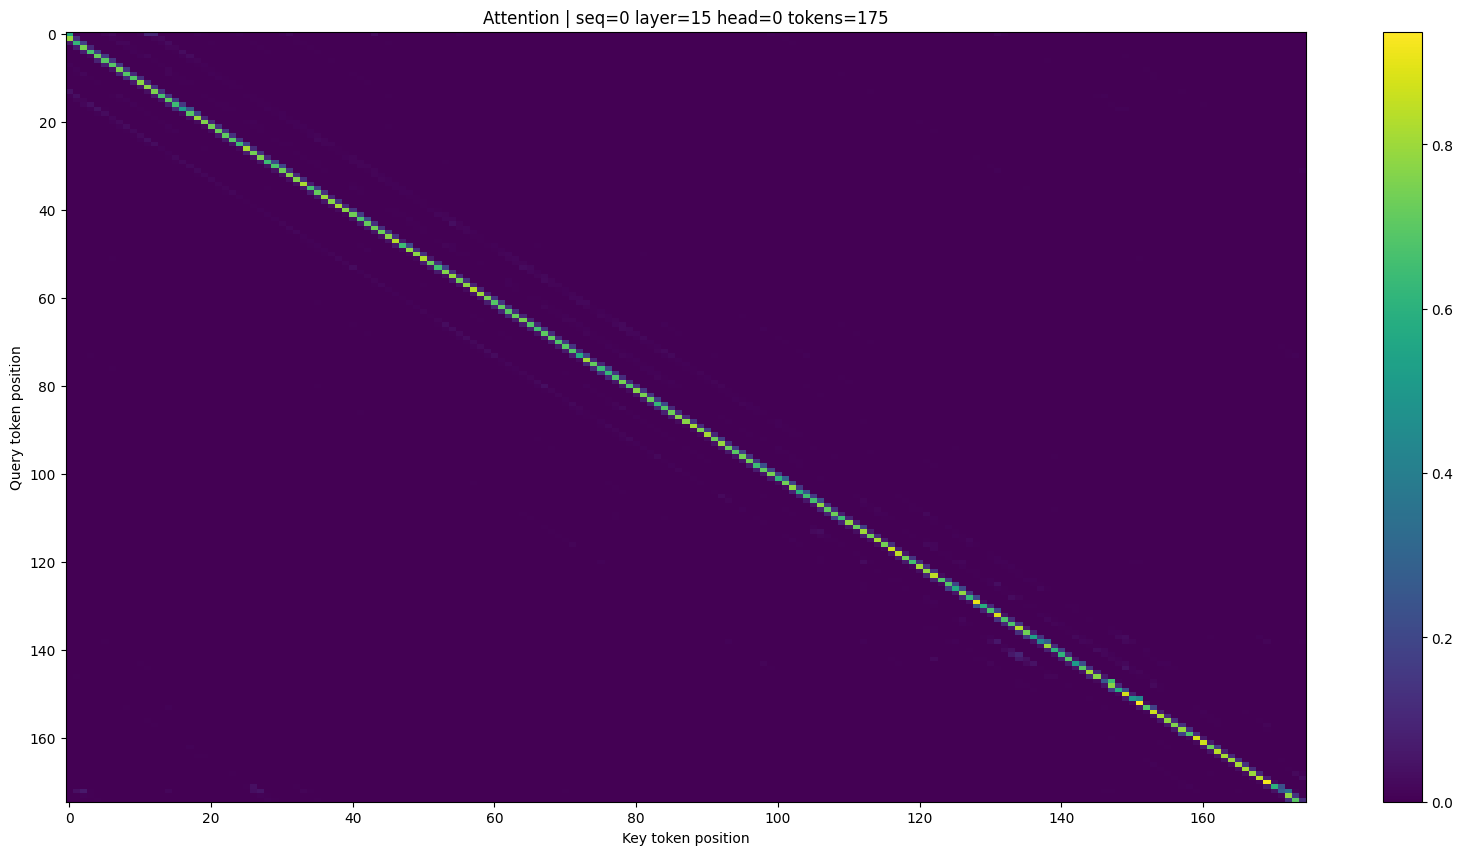

In [12]:
plot_attention(output_attentions, attention_mask, seq_index=0, layer=0, head=0)
plot_attention(output_attentions, attention_mask, seq_index=0, layer=1, head=0)
plot_attention(output_attentions, attention_mask, seq_index=0, layer=2, head=0)
plot_attention(output_attentions, attention_mask, seq_index=0, layer=5, head=0)
plot_attention(output_attentions, attention_mask, seq_index=0, layer=8, head=0)
plot_attention(output_attentions, attention_mask, seq_index=0, layer=9, head=0)
plot_attention(output_attentions, attention_mask, seq_index=0, layer=10, head=0)
plot_attention(output_attentions, attention_mask, seq_index=0, layer=15, head=0)



#plot_attention(output_attentions, attention_mask, seq_index=1, layer=-1, head=0)
#plot_attention(output_attentions, attention_mask, seq_index=2, layer=-1, head=0)

In [13]:
A = output_attentions[-1][0].mean(dim=0)  # (L,L)
off_diag_mass = A.sum() - torch.diagonal(A).sum()
print("Off-diagonal fraction:", off_diag_mass / A.sum())


Off-diagonal fraction: tensor(0.7967, grad_fn=<DivBackward0>)
